# WaterMark

## 读取数据

In [1]:
from data import load_random_images
from add_watermark import modify_red_to_green, add_wm_FFT, Watermark_k_layer
from attack import attack_all
import matplotlib.pyplot as plt
from utils import draw, numpy_to_images, images_to_numpy
from examine import caculate
import numpy as np
from tqdm import tqdm
import torch
import torch.fft as fft

In [2]:
def draw(data1, data2):
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for data1
    axs[0].hist(data1, bins=100, alpha=0.7, edgecolor='black')
    axs[0].set_title('Distribution of Data 1 (Normal)')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # Plot for data2
    axs[1].hist(data2, bins=100, alpha=0.7, edgecolor='black')
    axs[1].set_title('Distribution of Data 2 (Uniform)')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')

    # Show plots
    plt.tight_layout()
    plt.show()

In [3]:
n = 10 # 处理图片的batch_size
image_type = "RGB"
images_ori = load_random_images("D:/Doc/code/watermark/code/ILSVRC/Data/DET/test", 2*n, type=image_type)

k_list  = list(range(2,51))
image_show_num = 5
d_ssim = []
d_psnr = []
auc_crop = []
auc_compress = []
auc_ori = []
tpr_ori, tpr_crop, tpr_compress = [], [], []
img_show = {}

for k in tqdm(k_list):
    # 红绿分区
    # pre = images_ori[:n].copy()
    images_watermark = Watermark_k_layer.modify_k_percents(images_ori[:n],k)  # 取前n个加水印
    # sub = np.sum(pre - images_watermark)
    # print(sub)
    img_show[0] = images_ori[:image_show_num]
    img_show[k] = images_watermark[:image_show_num]
    images = images_watermark.copy() + images_ori[n:].copy()
    # 攻击
    auc = attack_all(images,k=k, type=image_type)
    auc_ori.append(auc[0][0])
    auc_crop.append(auc[1][0])
    auc_compress.append(auc[2][0])
    
    tpr_ori.append(auc[0][1]) 
    tpr_crop.append(auc[1][1])
    tpr_compress.append(auc[2][1])
    
    scores = caculate(images_ori[:n], images_watermark)
    d_ssim.append(scores[0])
    d_psnr.append(scores[1])

100%|██████████| 49/49 [03:02<00:00,  3.72s/it]


# 对比图片的精度损失

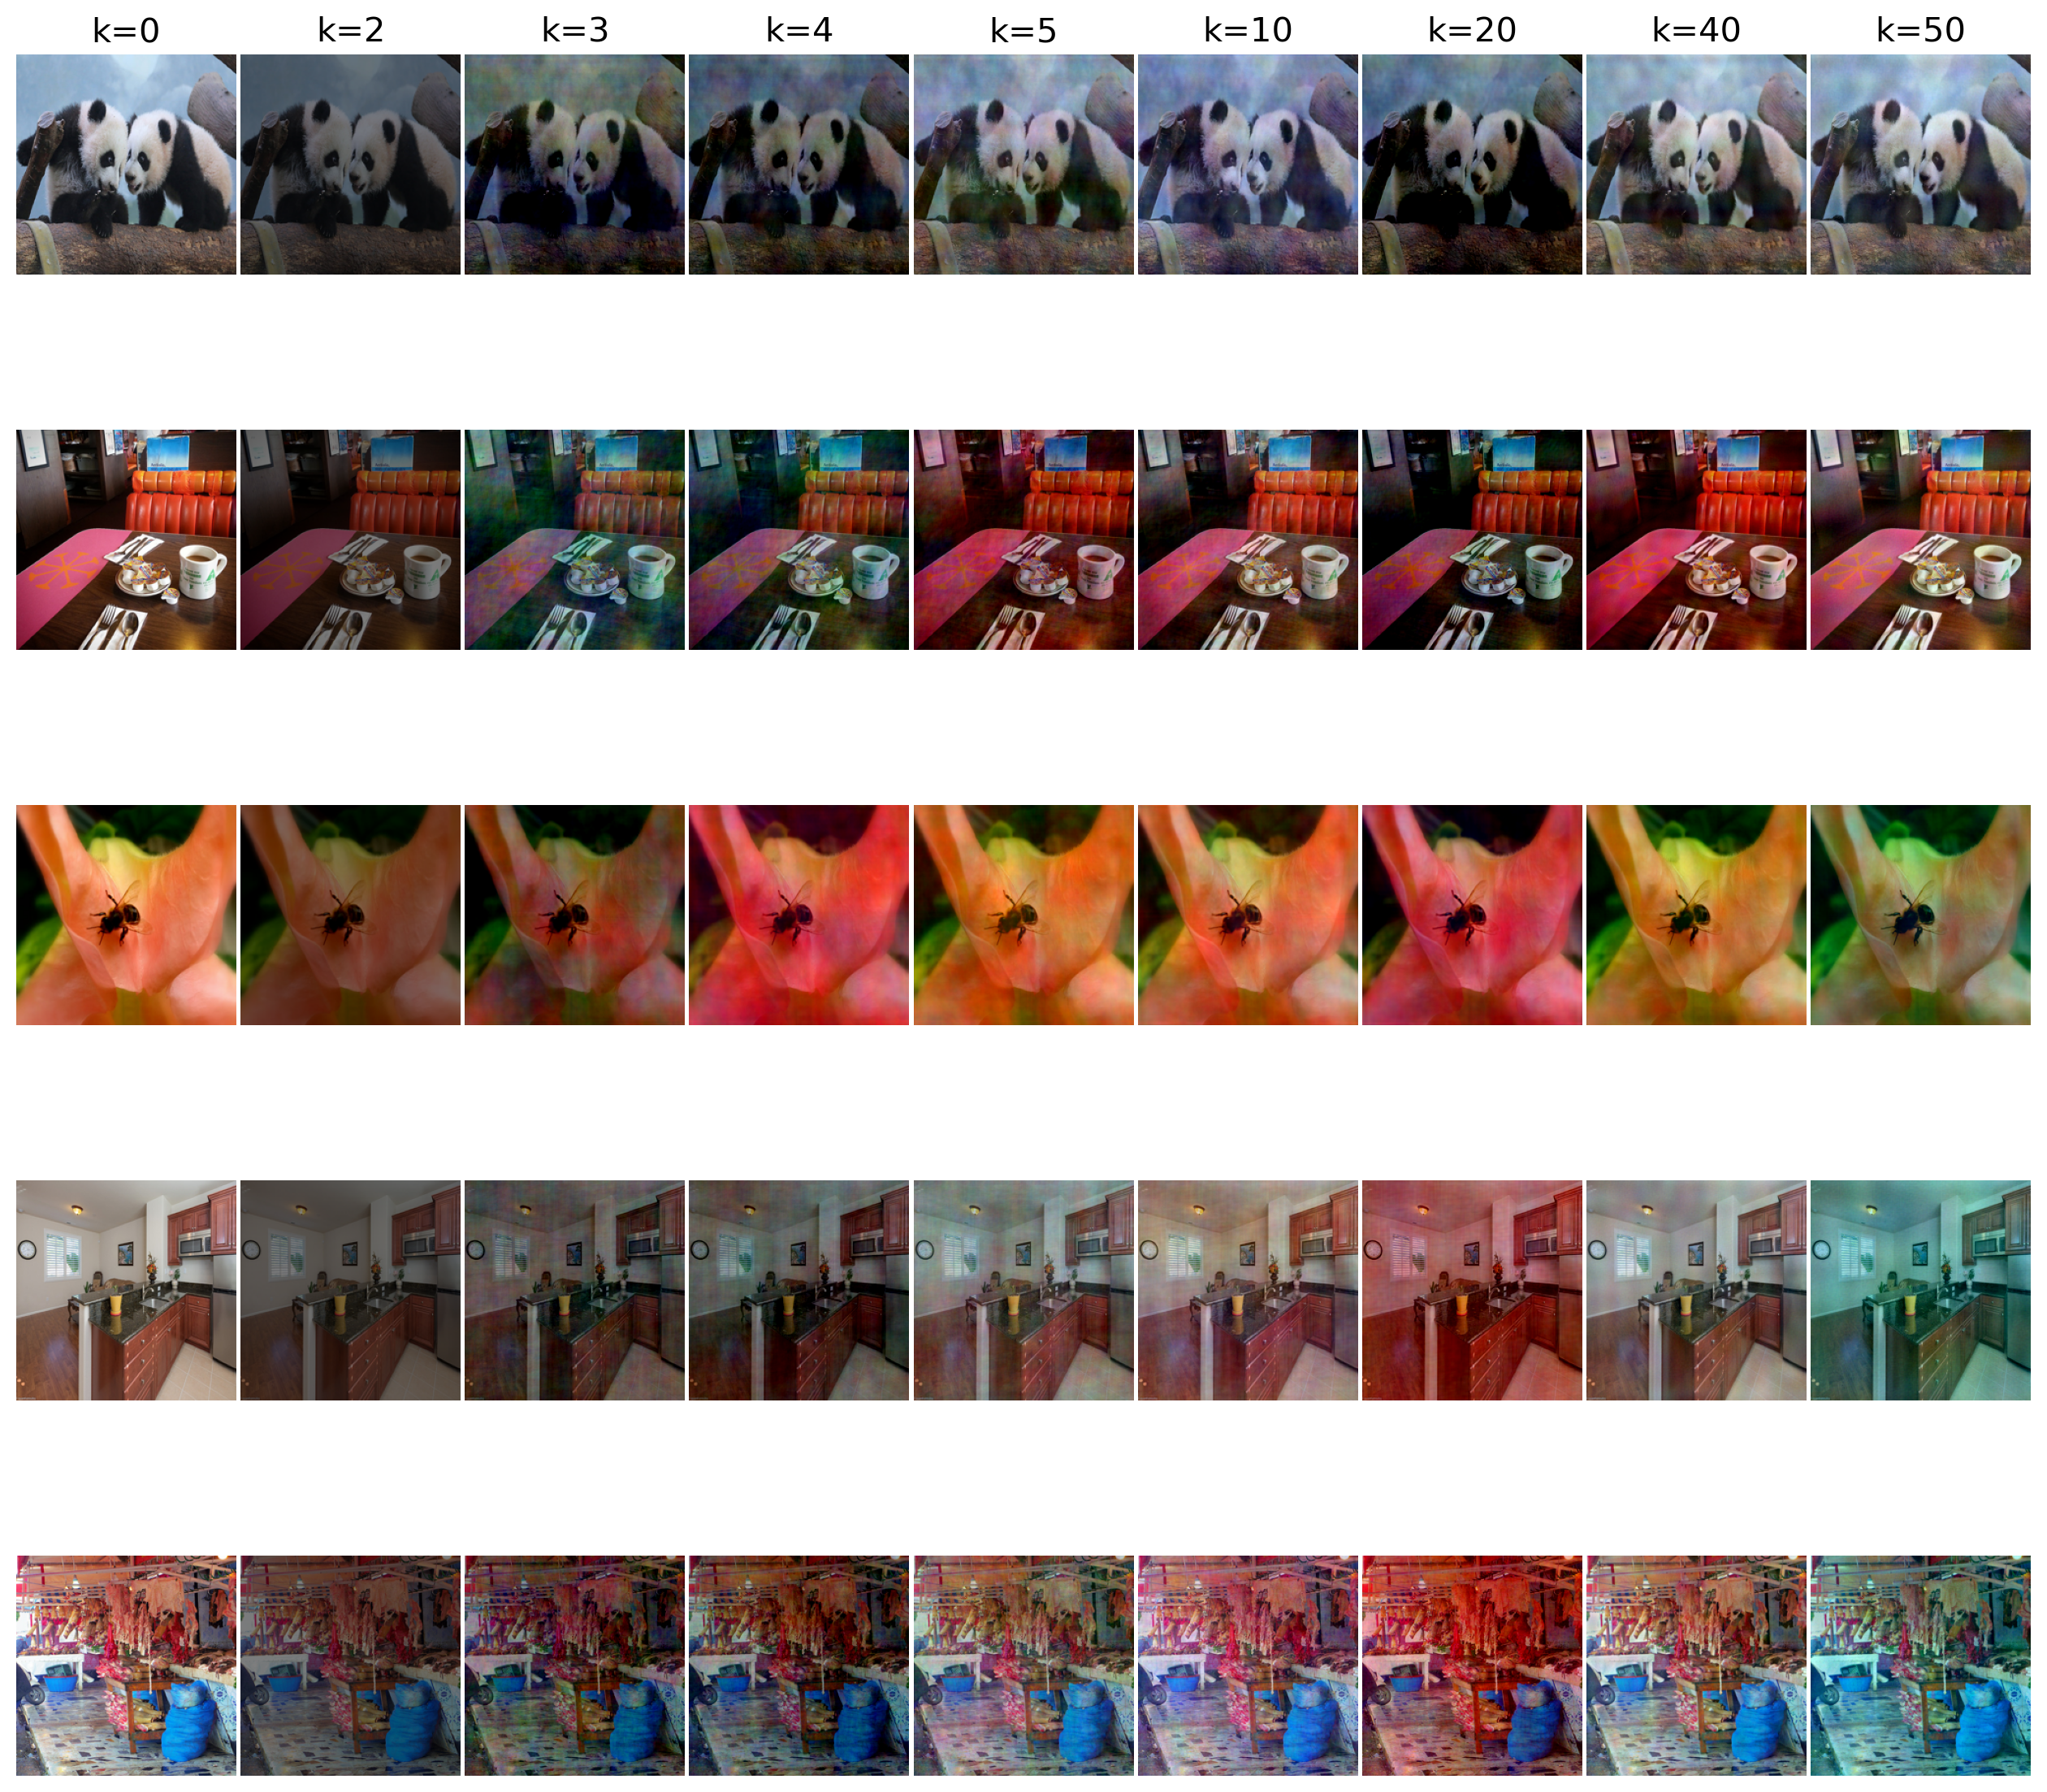

In [4]:
k_list_show = [0] + [2,3,4,5,10,20,40,50]
image_show_num =5
fig, axs = plt.subplots(image_show_num, len(k_list_show),  figsize=(16, 15), dpi=200)
for j in range(image_show_num):
    for i,k in enumerate(k_list_show):
        axs[j][i].imshow(img_show[k][j])
        if j == 0:
            axs[j][i].set_title(f"k={k}",fontsize=15)
        axs[j][i].axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.0001)
plt.show()


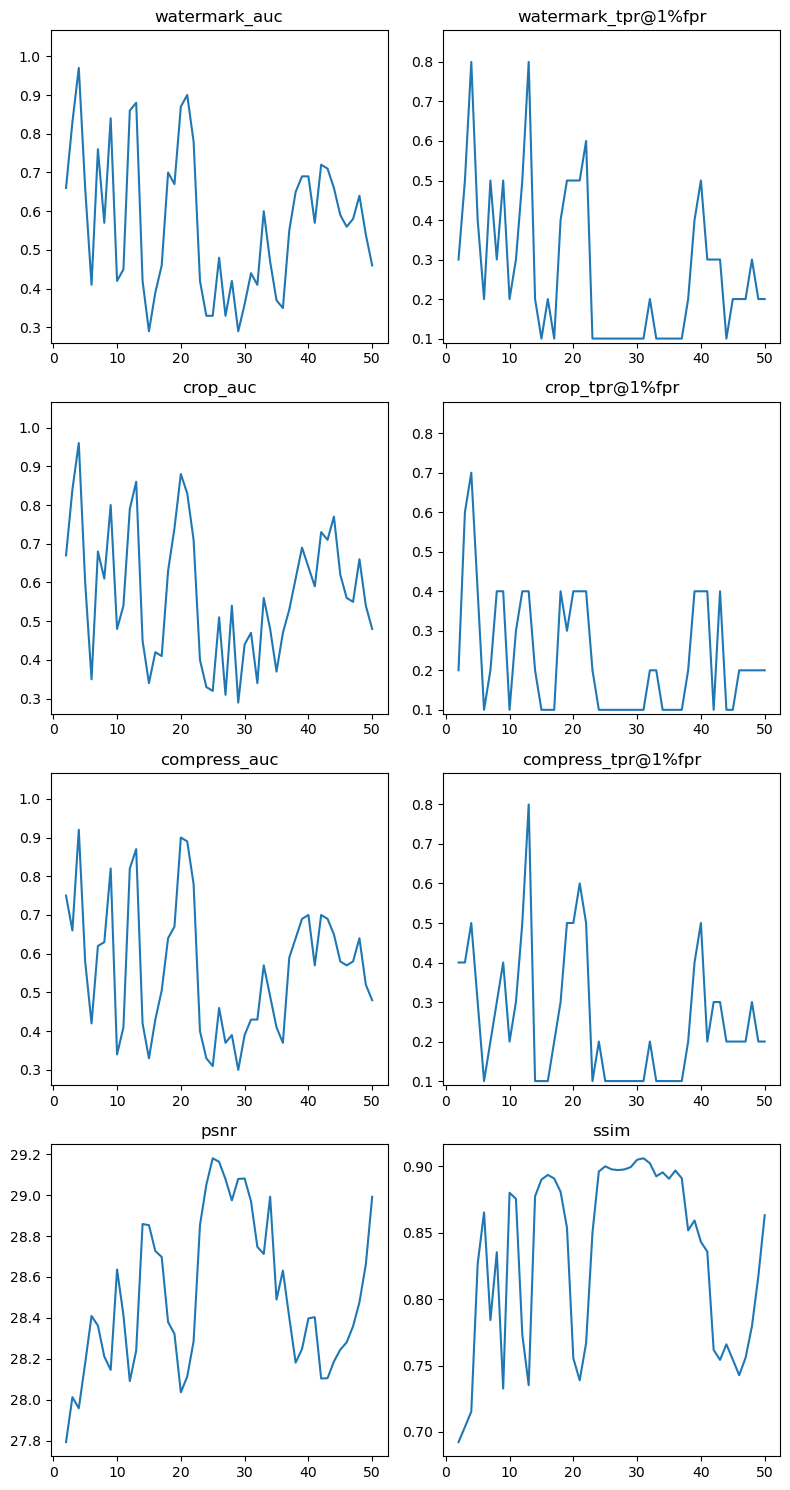

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(8, 15))
x = k_list
global_min_1 = min(min(auc_ori), min(auc_crop), min(auc_compress)) * 0.9
global_max_1 = max(max(auc_ori), max(auc_crop), max(auc_compress)) * 1.1

global_min_2 = min(min(tpr_ori), min(tpr_crop), min(tpr_compress)) * 0.9
global_max_2 = max(max(tpr_ori), max(tpr_crop), max(tpr_compress)) * 1.1
# 绘制子图
axs[0][0].plot(x, auc_ori)
axs[0][0].set_title("watermark_auc")
axs[0][1].plot(x, tpr_ori)
axs[0][1].set_title("watermark_tpr@1%fpr")
axs[0][0].set_ylim(global_min_1, global_max_1) 
axs[0][1].set_ylim(global_min_2, global_max_2) 

axs[1][0].plot(x, auc_crop)   
axs[1][0].set_title("crop_auc")
axs[1][1].plot(x, tpr_crop)   
axs[1][1].set_title("crop_tpr@1%fpr")
axs[1][0].set_ylim(global_min_1, global_max_1) 
axs[1][1].set_ylim(global_min_2, global_max_2) 


axs[2][0].plot(x, auc_compress)
axs[2][0].set_title("compress_auc")
axs[2][1].plot(x, tpr_compress)
axs[2][1].set_title("compress_tpr@1%fpr")
axs[2][0].set_ylim(global_min_1, global_max_1) 
axs[2][1].set_ylim(global_min_2, global_max_2) 

axs[3][0].plot(x, d_psnr)
axs[3][0].set_title("psnr")

axs[3][1].plot(x, d_ssim)
axs[3][1].set_title("ssim")

# 设置整体布局
plt.tight_layout()
plt.show()
# print(auc_ori)
# print(auc_crop)
# print(auc_compress)
# print(d_psnr)
# print(d_ssim)